# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 3:  Regularization and Cross-Validation

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [8pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).


### Answers

**1.1 Load the dataset from the csv file...**

In [7]:
bikes_df_raw = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [9]:
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


From a cursory glance, the variables seem to have a range and average which seems pretty normal without any glaring inconsistencies. 


In [10]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

The data types also make sense; the only possible improvement which could be made for memory optimizations is that the datatypes of `season`, `hour`, `holiday`, `weekday`, `workingday`, `weather` could be changed to `int8` since each of these variable's limited range is a subset of `int8`'s range

**1.2 Notice that the variable in column...**

In [32]:
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw.dteday, format='%Y-%m-%d')

**1.3 Create three new columns in the dataframe:...**

In [102]:
bikes_df_raw['year'] = [date.year - 2011 for date in bikes_df_raw['dteday']]
bikes_df_raw['month'] = [date.month for date in bikes_df_raw['dteday']]
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,datetime,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011-01-01,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011-01-01,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011-01-01,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011-01-01,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011-01-01,0,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` (please use the copy provided to you in `data/bikes_by_day.csv` for consistency and easy checking) to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') in the original hourly dataset into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 


### Answers

**2.1 Make a new dataframe...**

In [67]:
bikes_by_day = bikes_df_raw.copy()
bikes_by_day = bikes_by_day.groupby('dteday').aggregate(
    {'weekday' : min,
    'weather' : max,
    'season' : min,
    'temp' : np.mean,
    'atemp' : np.mean,
    'windspeed' : np.mean,
    'hum' : np.mean,
    'casual' : np.sum,
    'registered' : np.sum,
    'counts' : np.sum}
)
bikes_by_day.head()


,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


**2.2 Use `bikes_by_day` to visualize how the distribution...**

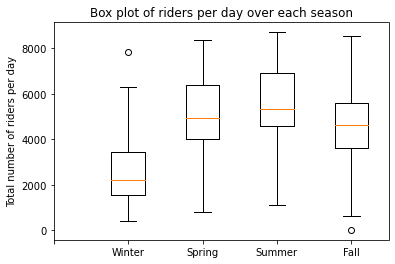

In [119]:
# use the copy provided for `bikers_by_day`
bikes_by_day = pd.read_csv("data/bikes_by_day.csv")
plt.boxplot([bikes_by_day['counts'][bikes_by_day.season == s] for s in [1,2,3,4]])
xlabels = ['','Winter','Spring','Summer','Fall']
xpos = np.arange(len(xlabels))
plt.xticks(xpos, xlabels)
plt.ylabel('Total number of riders per day')
plt.title('Box plot of riders per day over each season');


In [120]:
# get the outlier in winter
bikes_by_day[(bikes_by_day.counts > 7000) & (bikes_by_day.season == 1)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
441,2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833,1


In [121]:
# get the outlier in fall
bikes_by_day[(bikes_by_day.counts < 100) & (bikes_by_day.season == 4)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
667,2012-10-29,22,2,3,20,4,1,0.3582,0.44,0.4394,0.88,0


We see two main outliers - a very high count during the winter and a very low count in the fall. \
The one in the winter is on the 17th of March, 2012. We feel that it being a Sunday coupled with warm weather caused many people to go out and enjoy the day resulting in the high count. \
The one in the fall is on the 29th of October, 2012. Hurricane Sandy made landfall in New Jersey on this day which could have possibly made people wary of the weather and not go out.

**2.3 Convert the categorical attributes...**

In [122]:
bikes_df = pd.get_dummies(bikes_df_raw, columns=['season','weekday','month','weather'], drop_first=True)
bikes_df.tail()


,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weather_2,weather_3,weather_4
17374,2012-12-31,19,0,1,0.26,0.2576,0.60,0.1642,11,108,...,0,0,0,0,0,0,1,1,0,0
17375,2012-12-31,20,0,1,0.26,0.2576,0.60,0.1642,8,81,...,0,0,0,0,0,0,1,1,0,0
17376,2012-12-31,21,0,1,0.26,0.2576,0.60,0.1642,7,83,...,0,0,0,0,0,0,1,0,0,0
17377,2012-12-31,22,0,1,0.26,0.2727,0.56,0.1343,13,48,...,0,0,0,0,0,0,1,0,0,0
17378,2012-12-31,23,0,1,0.26,0.2727,0.65,0.1343,12,37,...,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 


In [143]:
train_data, test_data = train_test_split(bikes_df, test_size=0.5, stratify=bikes_df[['month_2', 'month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']], random_state=90)
train_data.head()


,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weather_2,weather_3,weather_4
11235,2012-04-18,8,0,1,0.50,0.4848,0.39,0.1940,25,551,...,0,0,0,0,0,0,0,0,1,0
11277,2012-04-20,2,0,1,0.44,0.4394,0.88,0.1940,3,18,...,0,0,0,0,0,0,0,0,0,0
11759,2012-05-10,4,0,1,0.46,0.4545,0.77,0.1940,0,2,...,0,0,0,0,0,0,0,0,0,0
9732,2012-02-15,11,0,1,0.36,0.3333,0.53,0.2836,13,125,...,0,0,0,0,0,0,0,0,0,0
4876,2011-07-27,2,0,1,0.76,0.6970,0.52,0.2985,1,5,...,0,1,0,0,0,0,0,0,0,0


**2.5 Although we asked you to create your train and test set...**

In [226]:
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")
del BSS_train['dteday']
del BSS_test['dteday']


**2.6 Make a plot showing the _average_ number of casual and registered riders...**

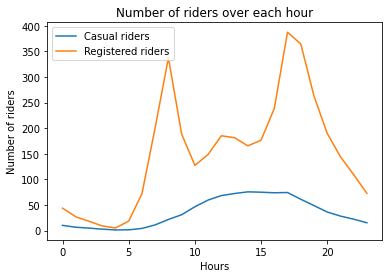

In [190]:
bikes_by_hour = bikes_df.copy()
bikes_by_hour = bikes_by_hour.groupby('hour').aggregate(
    {'casual' : np.mean,
     'registered' : np.mean}
)
plt.plot(bikes_by_hour['casual'], label="Casual riders")
plt.plot(bikes_by_hour['registered'], label="Registered riders")
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Number of riders')
plt.title('Number of riders over each hour');

Similar to the previous pset, here we again see the high number of registered riders during the 9am and the 5pm marks (rush hours when people usually go to their offices and come back home respectively). This makes sense since those relying on bikes to go to work usually register.


On the other hand, causal riders usually hit the peak during midday without any other peaks. This suggests that people usually go on leisure rides around midday to enjoy the warm weather at that time of day.


---

<div class='exercise'> <b> Question 3 [25pts]: Linear Regression to Model Hourly Ridership </b> </div>

**3.1** Use a linear regression model to formally test (via a probabilistic-based hypothesis test) whether `counts` is significantly different in the summer than the other months combined.  Be sure to interpret the results.  

**3.2** Use a resampling method to determine whether `counts` is significantly different in the summer than the other months combined.  How do these results compare to **3.1**?

**3.3** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was directly derived from and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.4** Examine the estimated coefficients and report which ones are statistically significant (at a significance level of $\alpha = 0.05$). 

**3.5** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.6** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


### Answers

**3.1 Use a linear regression model to formally test...**

In [167]:
X = sm.add_constant(BSS_train['summer'])

ols_model = sm.OLS(BSS_train['counts'], X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     192.2
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           3.02e-43
Time:                        01:34:51   Log-Likelihood:                -57424.
No. Observations:                8689   AIC:                         1.149e+05
Df Residuals:                    8687   BIC:                         1.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.5887      2.237     78.044      0.000     170.204     178.974
summer        60.9071      4.393     13.864      0.000      52.295      69.519
==============================================================================
Omnibus:                     1616.728   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2773.202
Skew:                           1.220   Prob(JB):                         0.00
Kurtosis:                       4.305   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We want to difference between the counts in the summer and other seasons by using a t-test.

The null hypthesis ($H_0$) is that the true difference between the means of the counts in summer vs the other seasons combined is zero.\
The alternate hypothesis ($H_1$) is that the true difference is different from zero.

The $t-value$ is $13.864$ and the $p-value$ is nearly $0$.

The difference in the mean is 60.9071

**3.2 Use a resampling method to...**

In [177]:
regress1 = LinearRegression(fit_intercept=True).fit(BSS_train[['counts']], BSS_train['summer'])
print("Observed beta1 =", regress1.coef_)


Observed beta1 = [0.00035541]


Empirical estimate of the p-value based on 1000 iterations is: 1.0


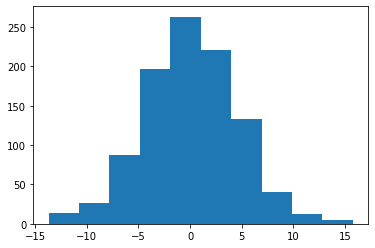

In [175]:

nperms = 1000
nboots = 1000
n = np.size(BSS_train['counts'])
beta1_perms = []

# use a for loop to do the reampling for us
for boot in np.arange(nboots):
    y_perm = np.random.choice(BSS_train['counts'],size=n,replace=False)
    regress_perm = LinearRegression(fit_intercept=True).fit(BSS_train[['summer']], y_perm)

    beta1_perms.append(regress_perm.coef_[0])

plt.hist(beta1_perms)
print("Empirical estimate of the p-value based on 1000 iterations is:" , 
      np.mean(np.abs(beta1_perms)>np.abs(regress1.coef_[0])))

The sampling distribution based on this permutation test (derived using the null hypothesis) is no where close to the

**3.3 Use statsmodels to fit a multiple linear regression model...**

In [191]:
trivial_cols = ['casual','registered']

BSS_train = BSS_train.drop(trivial_cols, axis=1)
BSS_test = BSS_test.drop(trivial_cols, axis=1)

In [ ]:
######
# your code here
######

**3.4 Examine the estimated coefficients and report...**

In [ ]:
######
# your code here
######

**3.5 You should see some strange estimates for the predictors representing months...** 

*your answer here*

**3.6 To diagnose the model, make two plots:...**

In [ ]:
######
# your code here
######

*your answer here*


---

<div class='exercise'> <b> Question 4 [22pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` and `BSS_test` (if any of them still remain) to reduce the collinearity in the predictor space.  The variables that remain should be: 

`['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
  'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with `degree=2` you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the numeric predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a numeric feature times a month of weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For polynomials of `degrees = [3,6,9,12,15,18]`:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Which model would you select, and why?

### Answers

**4.1 Drop...**

In [262]:
######
# your code here
######

BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
BSS_test = BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)



KeyError: "['workingday' 'atemp' 'spring' 'summer' 'fall'] not found in axis"

In [263]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

**4.2 Write a function to standardize...**


In [264]:
def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    train = train_data
    test = test_data
    
    for col in cols_to_scale:
        mean = train[col].mean()
        std = train[col].std()
        train[col] = (train[col] - mean) / std
        test[col] = (test[col] - mean) / std
        
    return train, test

In [230]:
def split_columns(df, target_col, drop_columns):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """
    X_train = df
    for col in drop_columns:
        del X_train[col]
        
    y_train = df[target_col]
    return X_train, y_train



In [232]:
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
non_binary_columns = BSS_train.columns.difference(binary_columns)

In [265]:
practice_X_train = BSS_train
practice_X_test = BSS_test

practice_X_train_scaled, practice_X_test_scaled = scale_datasets(practice_X_train, practice_X_test, non_binary_columns)
practice_X_train_scaled.describe()


,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,7.326526e-17,0.029347,1.077015e-15,1.180187e-14,3.874411e-14,7.452489e-14,4.929498e-17,-7.141255e-17,6.602051e-17,0.077224,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000000e+00,0.168788,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.266962,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666263e+00,0.000000,-1.006755e+00,-2.474050e+00,-3.251787e+00,-1.546547e+00,-7.225013e-01,-1.020019e+00,-1.043814e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042200e-01,0.000000,-1.006755e+00,-8.122357e-01,-7.554373e-01,-6.986934e-01,-6.418821e-01,-7.955984e-01,-8.288580e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782341e-02,0.000000,9.931755e-01,1.867126e-02,-2.733539e-02,2.745877e-02,-3.798699e-01,-2.477470e-01,-2.556411e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.198668e-01,0.000000,9.931755e-01,8.495782e-01,8.047811e-01,5.118307e-01,2.650834e-01,4.387175e-01,5.159971e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638236e+00,1.000000,9.931755e-01,2.511392e+00,1.948941e+00,5.355550e+00,6.573532e+00,4.828130e+00,4.335606e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [266]:
######
# your code here
######

def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    poly_dataset = dataset
    for column in columns:
        for i in range(degree+1):
            if i == 0 or i == 1:
                continue
            column_name = column + "^" + str(i)
            poly_dataset[column_name] = dataset[column] ** i
    
    return poly_dataset

In [267]:
# testing the function
practice_X_train_poly = add_poly_features(practice_X_train_scaled, 3, non_binary_columns)
practice_X_train_poly.columns


Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'casual^2', 'casual^3', 'counts^2',
       'counts^3', 'hour^2', 'hour^3', 'hum^2', 'hum^3', 'registered^2',
       'registered^3', 'temp^2', 'temp^3', 'windspeed^2', 'windspeed^3',
       'year^2', 'year^3'],
      dtype='object')

**4.4 Write code to add interaction terms to the model...**

In [268]:
interaction_terms = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(
    BSS_train[['hour','hum','windspeed']], 
    BSS_train[['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 
              'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
              'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']]
)


In [269]:
######
# your code here
######

def build_interaction(df, interact_left, interact_right):
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    result_df = df
    for column_1 in interact_left:
        for column_2 in interact_right:
            column_name = column_1+"*"+column_2 
            result_df[column_name] = result_df[column_1] * result_df[column_2]

    return result_df



In [270]:
practice_X_train_poly.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'casual^2', 'casual^3', 'counts^2',
       'counts^3', 'hour^2', 'hour^3', 'hum^2', 'hum^3', 'registered^2',
       'registered^3', 'temp^2', 'temp^3', 'windspeed^2', 'windspeed^3',
       'year^2', 'year^3'],
      dtype='object')

In [280]:
practice_X_train_poly_interactions = build_interaction(
    practice_X_train_poly, 
    ['hour','hum','windspeed'],
    ['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
     'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
)
for i in practice_X_train_poly_interactions.columns:
    print(i, end=', ')
practice_X_train_poly_interactions.head()

hour, holiday, year, temp, hum, windspeed, casual, registered, counts, Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct, Nov, Dec, Mon, Tue, Wed, Thu, Fri, Sat, Cloudy, Snow, Storm, casual^2, casual^3, counts^2, counts^3, hour^2, hour^3, hum^2, hum^3, registered^2, registered^3, temp^2, temp^3, windspeed^2, windspeed^3, year^2, year^3, hour*Feb, hour*Mar, hour*Apr, hour*May, hour*Jun, hour*Jul, hour*Aug, hour*Sept, hour*Oct, hour*Nov, hour*Dec, hour*Mon, hour*Tue, hour*Wed, hour*Thu, hour*Fri, hour*Sat, hum*Feb, hum*Mar, hum*Apr, hum*May, hum*Jun, hum*Jul, hum*Aug, hum*Sept, hum*Oct, hum*Nov, hum*Dec, hum*Mon, hum*Tue, hum*Wed, hum*Thu, hum*Fri, hum*Sat, windspeed*Feb, windspeed*Mar, windspeed*Apr, windspeed*May, windspeed*Jun, windspeed*Jul, windspeed*Aug, windspeed*Sept, windspeed*Oct, windspeed*Nov, windspeed*Dec, windspeed*Mon, windspeed*Tue, windspeed*Wed, windspeed*Thu, windspeed*Fri, windspeed*Sat, 

,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,1.350889,0,0.993176,-1.331553,-0.131350,0.511831,-0.480644,-0.683388,-0.702089,0,...,0.0,0.000000,0.0,0.511831,0.0,0.0,0.0,0.511831,0.0,0.0
1,0.776193,0,-1.006755,0.641851,1.064817,0.511831,0.224774,1.831448,1.590779,0,...,0.0,0.511831,0.0,0.000000,0.0,0.0,0.0,0.511831,0.0,0.0
2,-0.373198,0,0.993176,1.368895,0.180694,-0.214322,0.365857,0.953566,0.896304,0,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.214322,-0.0,-0.0
3,0.776193,0,0.993176,0.641851,-2.107627,0.875312,3.006135,0.471721,1.215983,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,-0.516872,0,0.993176,-1.643143,-1.171496,-0.456913,-0.541108,-0.617382,-0.663507,0,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [ ]:
######
# your code here
######

def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
 
    return x_train,y_train, x_val,y_val


**4.6 For polynomials of `degrees = [3,6,9,12,15,18]`:...**

In [ ]:
######
# your code here
######

**4.7 Which model would you select, and why?**

*your answer here*

---

<div class='exercise'> <b> Question 5 [25pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split (use `random_state=109`).  Build a table showing the validation set $R^2$ for the degree-15 polynomial model, regularized at the levels `alphas = np.exp(np.arange(-10,11,1))`. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring Ridge model above.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset (design matrix) with polynomial degree 2 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `alphas = np.exp(np.arange(-10,10,1))`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Build a plot which cleanly presents, for the 'main effect' features: 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso, so that each predictor's coefficient can be easily compared across the 3 models.  These main effect features should be: `['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.6** What differences do you see in the plot above comparing the 3 types of models?  Are any of the results surprising?

### Answers

**5.1 Let's try regularizing our models via...** 

In [ ]:
bikes_train, bikes_val = train_test_split(BSS_train, test_size=.2)

In [ ]:
######
# your code here
######


**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
######
# your code here
######


**5.3 It's time to see how well our selected model...**


In [ ]:
######
# your code here
######

*your answer here*


**5.4 Build a dataset with polynomial degree 1...**

In [ ]:
######
# your code here
######

**5.5  Build a plot which cleanly presents, for each feature in the data...**

In [ ]:
######
# your code here
######

**5.6 What differences do you see...**

*your answer here*

---